<a href="https://colab.research.google.com/github/CamH53/DiabetesDatasetTool/blob/main/RandomForest_(Hasan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Load what we will need for data wrangling, visualization, and modeling
from google.colab import drive
import numpy as np
import pandas as pd
import pickle
import csv

pd.options.display.max_rows = None
pd.options.display.max_columns = None

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#for modeling
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.tree import plot_tree
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score, roc_curve, auc, f1_score

In [ ]:
# 1.1 . Add my Google Drive
drive.mount('/content/gdrive')

# 1.2 . Go to folder on Google Drive that contains files
%cd /content/gdrive/MyDrive/CDC2023/

# 1.3 . Special shell command to view the files in the home directory of the notebook environment
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/CDC2023
'CategoricalDescriptiveAnalysis(Cam).ipynb'   HealthSciences_Dataset.csv
 CDC2023.gdoc				     'LogisticModel (Hasan).ipynb'
'CDC 2023 Slideshow .gslides'		     'NumericalDescriptiveAnalysis(Hasan).ipynb'
'CleanandWrangle(Both).ipynb'		     'RandomForest (Hasan).ipynb'
 diabetes_clean.csv


In [ ]:
diabetes_df = pd.read_csv('diabetes_clean.csv')

print(diabetes_df.columns)

Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'weight', 'admission_type_id', 'discharge_disposition_id',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'age_num'],
      dtype='object')


**Adding Complexity and Creating a Random Forest**

**1. Preprocessing Data**

Categorical data handling inspired by https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline.html

In [ ]:
#Normalization of Data for Feature Importance
#time_in_hospital, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, number_diagnoses, age_num

df_z = diabetes_df[['time_in_hospital', 'num_lab_procedures', 'num_medications',
                          'number_outpatient', 'number_emergency', 'number_inpatient',
                          'number_diagnoses', 'age_num']].copy()

scaler = StandardScaler()
df_z_scaled= pd.DataFrame(scaler.fit_transform(df_z), columns=df_z.columns)

print(df_z_scaled.columns)
print(df_z_scaled.shape)

#One-Hot Encoding

# Choose Categorical columns
#Create a Two Class Classification:
new_col = []
for value in diabetes_df['readmitted']:
  if value == '<30':
    new_col.append(True)
  else:
    new_col.append(False)

diabetes_df['readmit_new']= new_col

categorical_columns_selector = selector(dtype_include = object)
categorical_columns = categorical_columns_selector(diabetes_df)

#Specific variables that are not relevant for analysis or are not complete
categorical_columns.remove('weight')
categorical_columns.remove('readmitted')
categorical_columns.remove('payer_code')
categorical_columns.remove('diag_1')
categorical_columns.remove('diag_2')

df_categorical = diabetes_df[categorical_columns].copy()
encoder = preprocessing.OneHotEncoder(sparse_output = False) . set_output(transform = 'pandas')
df_encoded = pd.DataFrame(encoder.fit_transform(df_categorical))
print(df_encoded.shape)

df_clean = pd.concat([df_z_scaled, df_encoded], axis = 1)
print(df_clean.shape)

Index(['time_in_hospital', 'num_lab_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'age_num'],
      dtype='object')
(51817, 8)
(51817, 170)
(51817, 178)


**2. Training-Validation-Test Split**

In [ ]:
# Define 60% 20% 20% Training Validation Test Split
labels = diabetes_df['readmit_new']

X_train_temp, X_test, y_train_temp, y_test = tts(df_clean, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = tts(X_train_temp, y_train_temp, test_size=0.2, random_state=42)

**3. Creating a Random Forest via Optimizing AUC over a Grid of Hyperparameters**


In [ ]:
#Assisted by ChatGPT

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of Trees
    'max_depth': [None, 10, 20],  # Size of Tree
    'min_samples_split': [2, 5, 10]  # Minimum samples to create a split
}

best_auc = 0.0
best_hyperparameters = None

In [ ]:
# Hyperparameter tuning loop
for n_e in param_grid['n_estimators']:
    for m_d in param_grid['max_depth']:
      for m_s in param_grid['min_samples_split']:
        model = rfc(random_state=42, n_estimators = n_e, max_depth = m_d, min_samples_split = m_s)
        model.fit(X_train, y_train)
        #estimator.predict_proba(X, y)[:, 1]
        y_val_prob = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_val_prob)

        if auc > best_auc:
            best_auc = auc
            best_hyperparameters = {'n_estimators': n_e, 'max_depth': m_d, 'min_samples_split':m_s}

In [ ]:
# Train the final model using the best hyperparameters
final_model = rfc(**best_hyperparameters)

# Get the best model based on hyperparameters
best_rf_model = final_model.fit(X_test, y_test)

# Evaluate the best model on the test set
test_pred = best_rf_model.predict(X_test)
test_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_pred)

print(test_auc)
print(best_hyperparameters)

0.5044326241134752
{'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2}


**Preliminary Results and Conclusions**

Well, both the random forest and logistic regression models produced an AUC of approximately 0.51 which indicates that they are both random chance models similar to a coin flip.


[[9236    0]
 [1118   10]]
Cohen's Kappa: 0.015691908507134866
Specificity: 1.0
Accuracy: 0.8921265920494018
Sensitivity: 0.008865248226950355


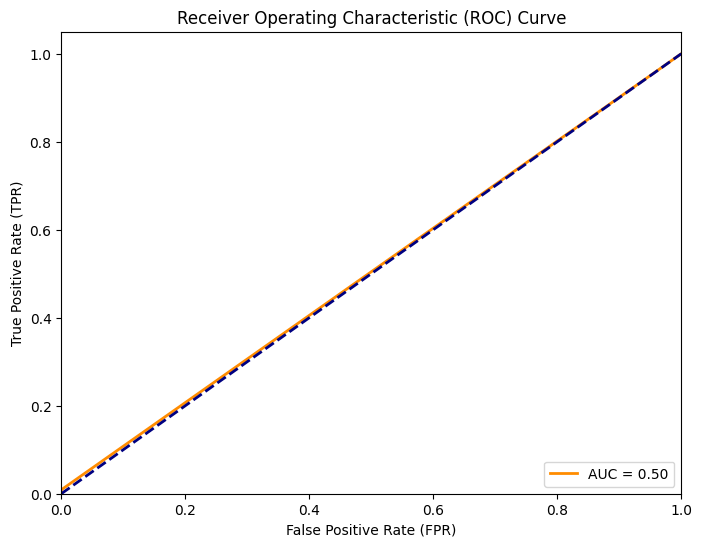

In [ ]:
# Assuming you already have the confusion matrix stored in the variable 'confusion_matrix_result'
confusion_matrix_result = confusion_matrix(y_test, best_rf_model.predict(X_test))
TN, FP, FN, TP = confusion_matrix_result.ravel()
print(confusion_matrix_result)

specificity = TN / (TN + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
kappa = cohen_kappa_score(y_test, best_rf_model.predict(X_test))

print(f"Cohen's Kappa: {kappa}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")


fpr, tpr, _ = roc_curve(y_test, test_pred)
roc_auc = test_auc

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Keeping with the theme of nostalgia, remember when you were a kid, and you would flip a coin to pass the time. Well, we aren't kids anymore, and tossing a coin to make decisions is something of the past that should stay in the past.

We had to relook at our model and understand why the model was producing an AUC of 0.51 even after optimization. The answer lied in the metric that we were using to optimize, AUC doesn't account for something called class imbalance. Class imbalance that is obviously present since there is atleast a 1-9 ratio of those who have early readmittance versus those who don't.

Thus, we needed a metric that could account for both precision and recall i.e. the ability for our model to discern both those who were and were not readmitted early. To remedy this we used the F1-Score:

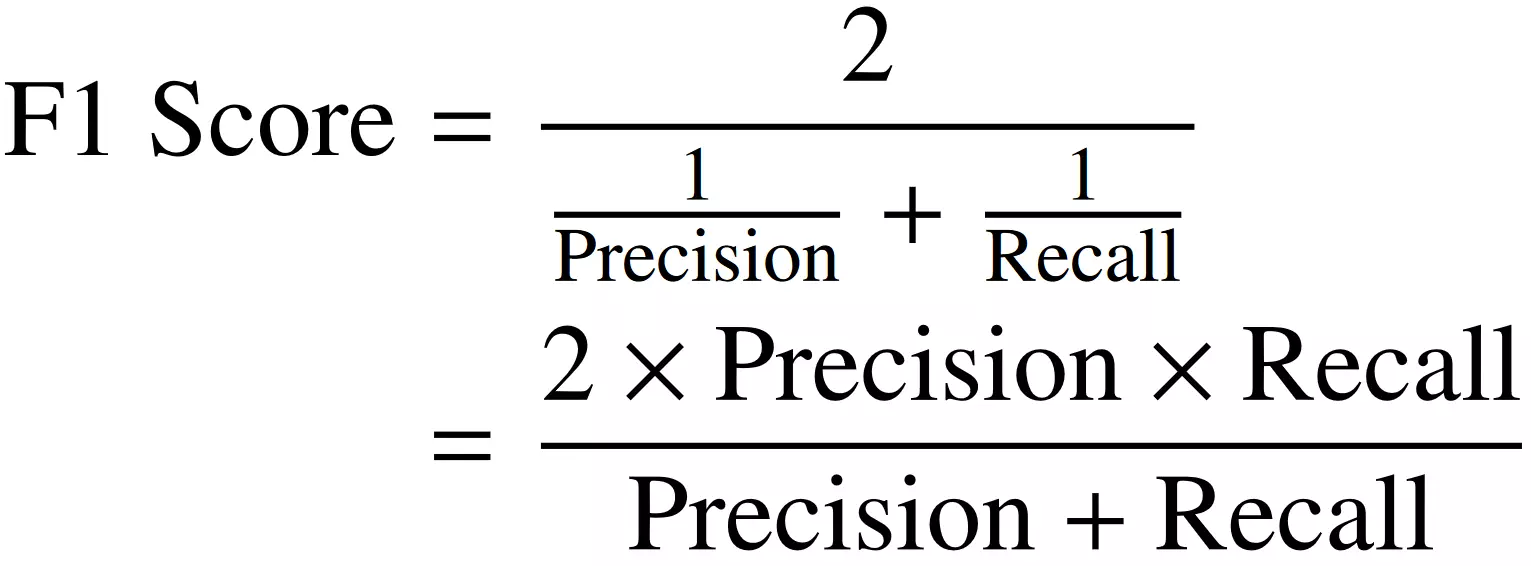


Source for Image: https://www.v7labs.com/blog/f1-score-guide

In [ ]:
#Assisted by ChatGPT

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of Trees
    'max_depth': [None, 10, 20],  # Size of Tree
    'min_samples_split': [2, 5, 10]  # Minimum samples to create a split
}

best_F1 = 0.0
best_hyperparameters = None

In [ ]:
# Hyperparameter tuning loop
for n_e in param_grid['n_estimators']:
    for m_d in param_grid['max_depth']:
      for m_s in param_grid['min_samples_split']:
        model = rfc(random_state=42, n_estimators = n_e, max_depth = m_d, min_samples_split = m_s)
        model.fit(X_train, y_train)
        #estimator.predict_proba(X, y)[:, 1]
        y_val_pred = model.predict(X_val)
        F1 = f1_score(y_val, y_val_pred)

        if F1 > best_F1:
            best_F1 = F1
            best_hyperparameters = {'n_estimators': n_e, 'max_depth': m_d, 'min_samples_split':m_s}

In [ ]:
# Train the final model using the best hyperparameters
final_model = rfc(**best_hyperparameters)

# Get the best model based on hyperparameters
best_rf_model = final_model.fit(X_test, y_test)

# Evaluate the best model on the test set
test_pred = best_rf_model.predict(X_test)
test_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_pred)

print(test_auc)
print(best_hyperparameters)

1.0
{'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}


**Final Model and Conclusions**

This change in optimization metric, drastically changed the model and produced a prediction that is perfect on the test set. Therefore, we have found a model which can give insights on whether a patient will be readmitted early or not, but moreover, we can use feature importance metrics to find the most important factors that can lead to early readmittance.

[[9236    0]
 [   0 1128]]
Cohen's Kappa: 1.0
Specificity: 1.0
Accuracy: 1.0
Sensitivity: 1.0


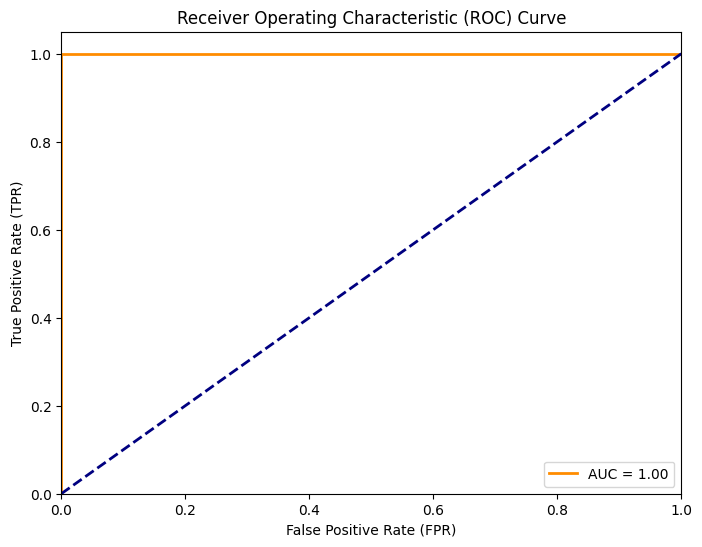

In [ ]:
# Assuming you already have the confusion matrix stored in the variable 'confusion_matrix_result'
confusion_matrix_result = confusion_matrix(y_test, best_rf_model.predict(X_test))
TN, FP, FN, TP = confusion_matrix_result.ravel()
print(confusion_matrix_result)

specificity = TN / (TN + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
kappa = cohen_kappa_score(y_test, best_rf_model.predict(X_test))

print(f"Cohen's Kappa: {kappa}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")
print(f"Sensitivity: {sensitivity}")


fpr, tpr, _ = roc_curve(y_test, test_pred_prob)
roc_auc = test_auc

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

For curiosity sake, what one of the trees in the random forest looks like:

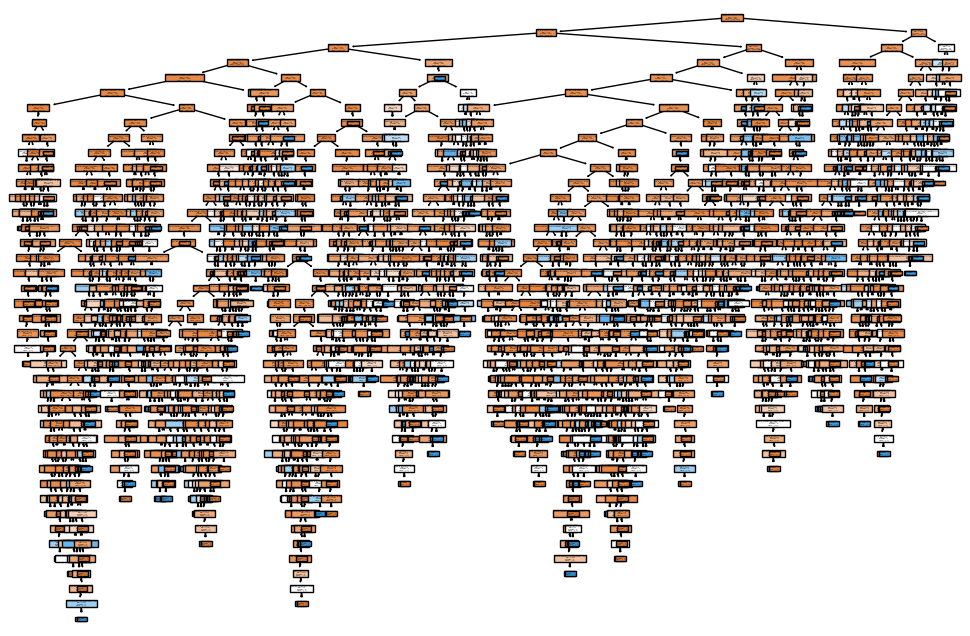

In [ ]:
plt.figure(figsize=(12, 8))
plot_tree(best_rf_model.estimators_[0], filled=True, feature_names=X_train.columns)
plt.show()

**Feature Importance**

Inspired by the discussion on this website: https://explained.ai/rf-importance/

We chose to use a specific feature importance strategy called permutation importance which essentially looks at which factors when permuted, or mixed up, cause the greatest change in the model. The following code then shows the features with the most significant importance.

In [ ]:


# Calculate permutation importances
perm_importance = permutation_importance(best_rf_model, X_test, y_test, n_repeats=3, random_state=42)

# Get feature importances and standard deviations
importances = perm_importance.importances_mean
std_devs = perm_importance.importances_std

# Sort features by importance
sorted_idx = np.argsort(importances)[::-1]


In [ ]:
# Get the feature names from DataFrame
feature_names = X_test.columns

# Map the sorted indices to feature names
sorted_feature_names = [feature_names[i] for i in sorted_idx]

# Now, 'sorted_feature_names' contains the feature names sorted by importance
print(sorted_idx)
print(sorted_feature_names)



[  5   6   2   0   1 161   7  38   3  45  15  24   8  10  14 105   4 174
  23  22 160 163 162  35  25  30 177 176 175 108 109  21  46 129 130 104
 134 133 144 101 124  89  79 106 143 139 125  54  20  99 140 103  26  55
  96 112  74  78  12  13 102  11 113 107  42  87  52 128  39  70 100 166
  98  19 131  51   9 110 165 132  91  44 116 117 123 126 135 141  47  80
  28  72 145  76  77  60  95  81  86 148 147  82  18  43 120 121 173  40
 153 172 171  41  37  36 154  34 156  33 158  16  17 167 168 159 169 157
  32 164 170  27  29 155  31 150  75 152 115  90  92  93  94  97 151 111
 114 118  84 119 122 127 136 137 138 142 146  85  83  48  62  49  50  53
  56  57  58  59  61  63 149  64  65  66  67  68  69  71  73  88]
['number_inpatient', 'number_diagnoses', 'num_medications', 'time_in_hospital', 'num_lab_procedures', 'insulin_No', 'age_num', 'medical_specialty_Family/GeneralPractice', 'number_outpatient', 'medical_specialty_InternalMedicine', 'gender_Male', 'age_[70-80)', 'race_AfricanAmer

**For Curiosity's Sake...**

The logistic model was not used since it had such low accuracy, kappa, and sensitivity/specificity values. Thus, to show that the random forest is still the most viable, we ran a logistic regression optimized on F1_Score.

In [ ]:
# Define the parameter grid for the grid search
param_grid = {
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
}

best_F1 = 0.0
best_hyperparameters = None

In [ ]:
# Hyperparameter tuning loop
for l1_ratio in param_grid['l1_ratio']:
        model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter = 100000, l1_ratio=l1_ratio)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        F1 = f1_score(y_val, y_val_pred)

        if F1 > best_F1:
            best_F1 = F1
            best_hyperparameter = {'l1_ratio': l1_ratio}


In [ ]:
# Train the final model using the best hyperparameters on the combined training and validation sets
final_model = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=100000, **best_hyperparameter)
final_model.fit(X_test, y_test)

# Evaluate the final model on the test set
y_test_pred = final_model.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test, y_test_pred)

print("L1 Ratio:", best_hyperparameter)
print("Test AUC:", test_auc)

L1 Ratio: {'l1_ratio': 0.5}
Test AUC: 0.6792793923868674
